In [120]:
import tarfile
import matplotlib.pyplot as plt
from pathlib import Path
from dysh.util.download import from_url
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.selection import Selection
from dysh.spectra.core import average
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation, t
import astropy.units as u
from RegscorePy import bic
# ...existing code...
from collections.abc import Sequence
# ...existing code...


In [131]:
path_to_raw_vegas = f"/home/sdfits/AGBT24B_251_02/AGBT24B_251_02.raw.vegas/" 
sdfits = GBTFITSLoad(path_to_raw_vegas, backend="VEGAS")

Flags were created from existing flag files. Use GBTFITSLoad.flags.show() to see them.


In [132]:
sdfits.flags.show()

 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------


In [133]:
BC22_scans =[18,20,22,24,26,28]  #[6, 8, 10, 12, 14, 16] #  # #

In [134]:
# Initialize lists and arrays to store flag channels, median flux, and MAD flux values
flag_list = []
median_flux_array = np.array([])
MAD_flux_array = np.array([])

# Iterate over each scan in BC22_scans
for scans in BC22_scans:
    # Load the spectra for the current scan
    Single_spectra1 = sdfits.getps(scan=scans, plnum=0)
    Single_spectra = Single_spectra1.timeaverage()
    flux_values = Single_spectra.flux.value  # Access flux values once

    # Calculate median flux and MAD flux for the current spectra
    median_flux = np.median(flux_values)
    median_flux_array = np.append(median_flux_array, median_flux)
    MAD_flux = median_abs_deviation(flux_values)
    MAD_flux_array = np.append(MAD_flux_array, MAD_flux)

    # Create a flag mask for values outside the median ± 5 * MAD range
    flag_mask = np.logical_or(flux_values < median_flux - 5 * MAD_flux,
                              flux_values > median_flux + 5 * MAD_flux)
    flag_chan = np.where(flag_mask)[0]

    # Define bounds and band for flagging
    lower_bound = 800
    upper_bound = 31000
    band = 5
    offsets = np.arange(-band, band + 1)

    # Filter valid flags within the bounds and create new_flag_chan using NumPy operations
    valid_flags = flag_chan[(flag_chan > lower_bound) & (flag_chan < upper_bound)]
    new_flag_chan = np.unique(np.concatenate([valid_flags + offset for offset in offsets] + 
                                             [np.array([i for i in range(0, lower_bound)])] + 
                                             [np.array([i for i in range(upper_bound, len(flux_values))])]))
    new_flag_chan = [int(i) for i in new_flag_chan if i >= 0 and i < len(flux_values)]
    print(f"{scans} number, flags:", new_flag_chan)

    # Flag the channels in the current scan
    sdfits.flag(scan=scans, channel=new_flag_chan, plnum=0)

    # Check if scans+1 is within a valid range before flagging
    if scans + 1 <= max(BC22_scans):
        sdfits.flag(scan=scans + 1, channel=new_flag_chan, plnum=0)

    # Append the new_flag_chan to the flag_list
    flag_list.append(new_flag_chan)

18 number, flags: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 2

In [135]:
sdfits.flags.show()

 ID    TAG    SCAN PLNUM               CHAN               # SELECTED
--- --------- ---- ----- -------------------------------- ----------
  0 901d6f441   18     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  1 25bd8d269   19     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
 10 35d932cb2   28     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  2 ad0ecdbc9   20     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  3 36d9ffe60   21     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  4 92dcf8ca9   22     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  5 ae754187c   23     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  6 1d299304d   24     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  7 cd5eff026   25     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  8 7ed2b8972   26     0 [0,1,2,3,4,5,6,...5,32766,32767]        122
  9 f2a018fe4   27     0 [0,1,2,3,4,5,6,...5,32766,32767]        122


INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]


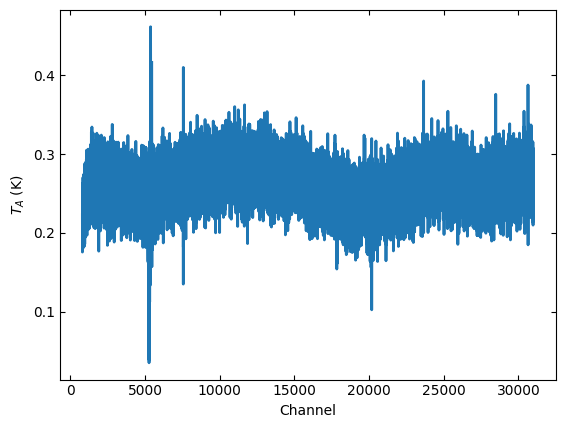

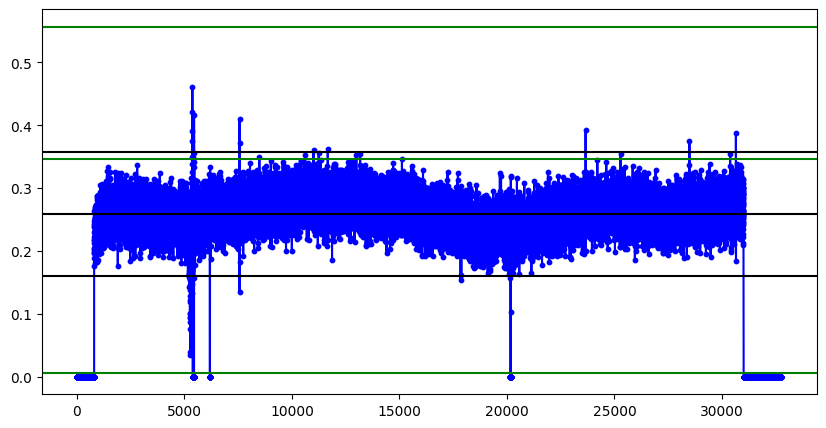

In [146]:
ps_scanblock = sdfits.getps(scan=BC22_scans, plnum=0, apply_flags=True)
ps = ps_scanblock.timeaverage()
ps.plot(xaxis_unit="chan")
fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(range(0, len(ps.flux.value)),ps.flux.value, color='b', s=10)
ax.plot(ps.flux.value, color='b')

ax.axhline(np.median(ps.flux.value), color='k')
ax.axhline(np.median(ps.flux.value) - 5*median_abs_deviation(ps.flux.value), color='k')
ax.axhline(np.median(ps.flux.value)+ 5*median_abs_deviation(ps.flux.value), color='k')


ax.axhline(max(median_flux_array), color='g')
ax.axhline(min(median_flux_array - 5*MAD_flux_array), color='g')
ax.axhline(max(median_flux_array+ 5*MAD_flux_array), color='g')

INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]


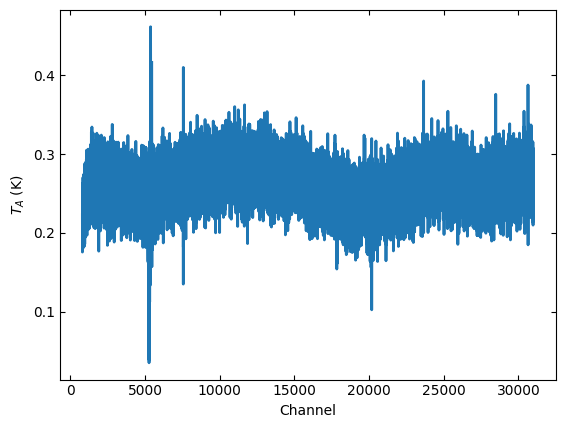

In [137]:
# Load the spectra for the current scan
flagged_spectra1 = sdfits.getps(scan=BC22_scans, plnum=0)
flagged_spectra = flagged_spectra1.timeaverage()
flagged_spectra.plot(xaxis_unit="chan")
flagged_flux_values = flagged_spectra.flux.value 


In [138]:

# Calculate median flux and MAD flux for the current spectra
fmedian_flux = np.median(flagged_flux_values)
fMAD_flux = median_abs_deviation(flagged_flux_values)


# Create a mask for values within the median ± 3 * MAD range
mask = np.logical_and(flagged_flux_values > fmedian_flux - 3 * fMAD_flux,
                        flagged_flux_values < fmedian_flux + 3 * fMAD_flux)
exclude_mask = np.logical_or(flagged_flux_values < fmedian_flux - 3 * fMAD_flux,
                        flagged_flux_values > fmedian_flux + 3 * fMAD_flux)
exclude_chan = np.where(exclude_mask)[0]
mask_chan = np.where(mask)[0]


In [ ]:
flagged_flux_values[mask_chan]

np.float64(-0.17328563147495232)

In [83]:
# check if there is 0 in the flagged_flux_values
print(np.where(flagged_flux_values[mask_chan] == np.nan)[0])


[]


In [13]:

pval = []
for i in range(0, 9):
    order = i
    coeff, cov = np.polyfit(mask_chan, flagged_flux_values[mask_chan], deg = order, cov=True)
    print(coeff)
    if min(np.diag(cov)) < 0:
        sigma = np.ones(order + 1) * 1e6
    else:
        sigma = np.sqrt(np.diag(cov))
    t_test = coeff[0] / sigma[0]  # sigma = std dev
    dof = len(mask_chan) - (order + 1) - 1  # degree of freedom
    print(dof)
    p = 2 * t.cdf((-abs(t_test)), dof)  # probability distribution function
    pval.append(p)
    if p > 0.05:
        recommended_order = order - 1 if order > 0 else 0
        break
    print(f"Order: {order}, p-value: {p}")
if pval[-1] <= 0.05:
    recommended_order = 9

print(f"Scan BC22 recommended order: {recommended_order}")

[0.26070349]
29273
Order: 0, p-value: 0.0
[-7.37666811e-08  2.61882144e-01]
29272
Order: 1, p-value: 5.167451439059581e-06
[-4.18273835e-12  5.93297532e-08  2.61143170e-01]
29271
Order: 2, p-value: 0.04382695694492242
[ 1.35692842e-14 -6.51241546e-10  8.48175307e-06  2.36293749e-01]
29270
Order: 3, p-value: 0.0
[-1.34721735e-19  2.21433909e-14 -8.29503994e-10  9.81228559e-06
  2.33748012e-01]
29269
Order: 4, p-value: 7.884792781656541e-05
[-2.03494594e-22  1.60570539e-17 -4.41600053e-13  4.90711078e-09
 -1.87335454e-05  2.73431690e-01]
29268
Order: 5, p-value: 0.0
[ 1.00550099e-26 -1.16324354e-21  5.11041535e-17 -1.05248147e-12
  1.00607353e-08 -3.74334447e-05  2.93740156e-01]
29267
Order: 6, p-value: 6.415768216792953e-70
[ 3.54000183e-30 -3.83923407e-25  1.63221128e-20 -3.42996752e-16
  3.69800654e-12 -1.94384990e-08  4.50084756e-05  2.20796253e-01]
29266
Order: 7, p-value: 0.0
[-7.83497579e-35  1.35102212e-29 -9.05630783e-25  3.07957919e-20
 -5.71820774e-16  5.75831817e-12 -2.940033

In [25]:
import numpy as np
from scipy.stats import norm  # Use normal distribution for Z-test

pval = []
for i in range(0, 9):
    order = i
    coeff, cov = np.polyfit(mask_chan, flagged_flux_values[mask_chan], deg=order, cov=True)
    print(coeff)
    
    if min(np.diag(cov)) < 0:
        sigma = np.ones(order + 1) * 1e-6
    else:
        sigma = np.sqrt(np.diag(cov))
    
    z_test = coeff[0] / sigma[0]  # Standard normal test statistic
    p = 2 * norm.cdf(-abs(z_test))  # Compute p-value using normal distribution
    
    pval.append(p)
    
    if p > 0.05:
        recommended_order = order - 1 if order > 0 else 0
        break
    
    print(f"Order: {order}, p-value: {p}")

if pval[-1] <= 0.05:
    recommended_order = 9

print(f"Scan BC22 recommended order: {recommended_order}")


[-0.17141026]
Order: 0, p-value: 0.0
[ 3.92195479e-08 -1.72034968e-01]
Order: 1, p-value: 0.011113805281739508
[ 3.20667261e-12 -6.25241884e-08 -1.71473574e-01]
Scan BC22 recommended order: 1


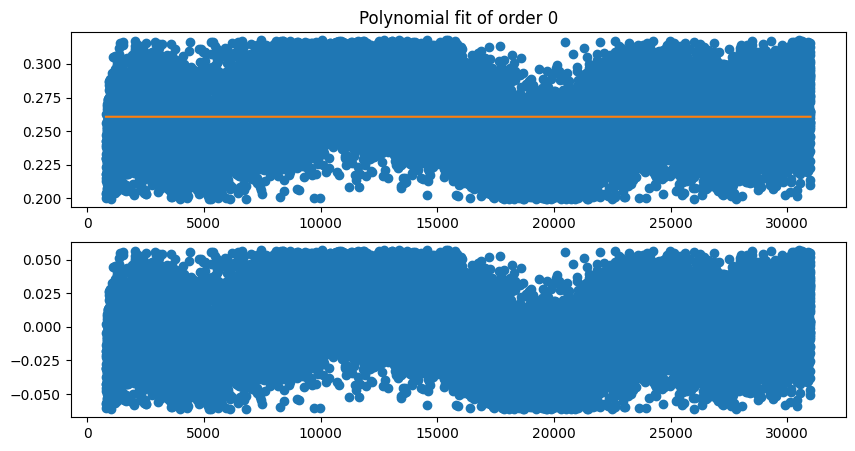

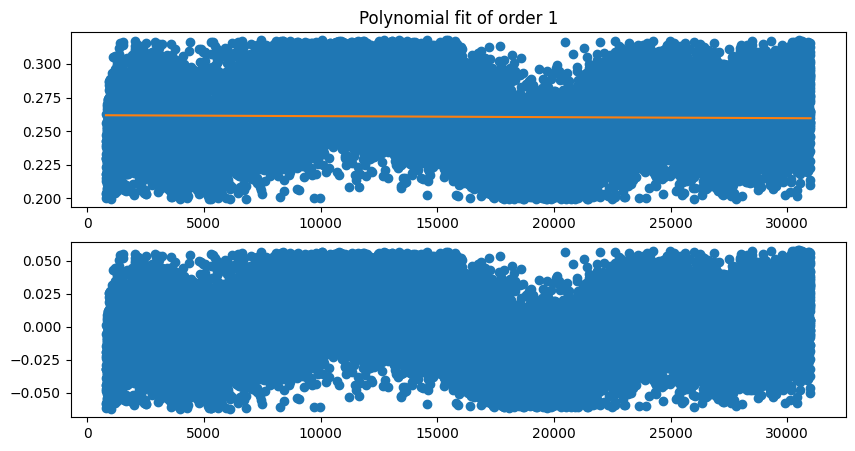

Order: 1, BIC: -217847.88275897695, ΔBIC: -inf


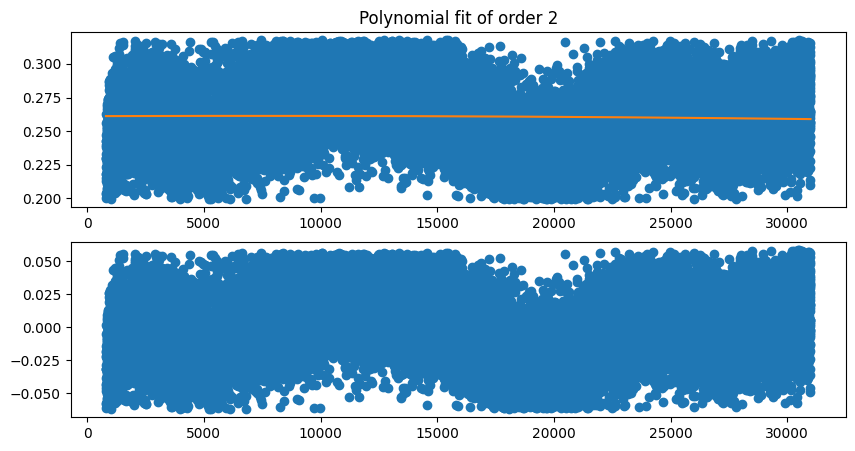

Order: 2, BIC: -217841.66197161734, ΔBIC: 6.2207873596053105


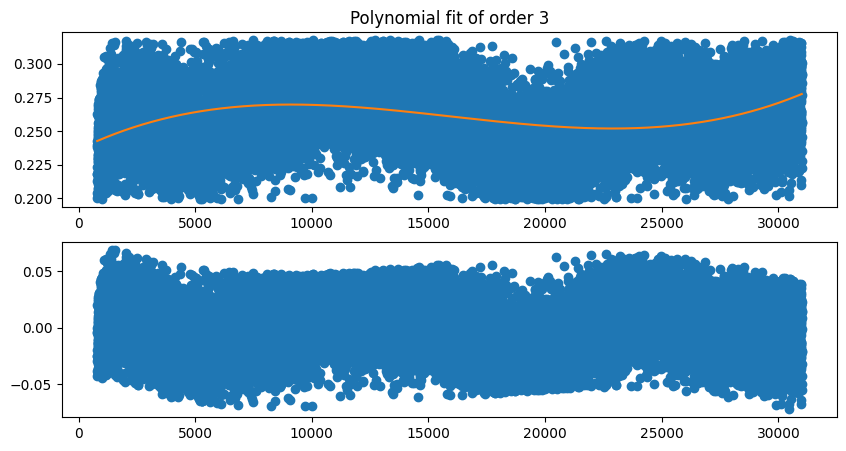

Order: 3, BIC: -220444.6182042884, ΔBIC: -2602.956232671044


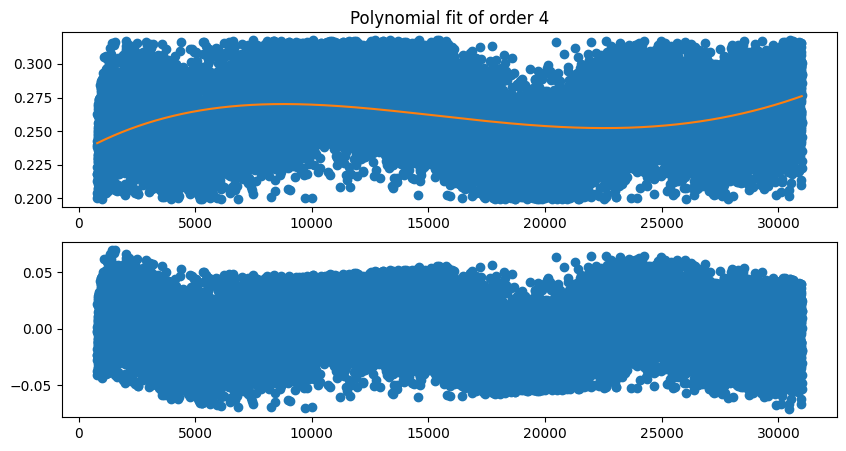

Order: 4, BIC: -220449.92236154026, ΔBIC: -5.3041572518704925


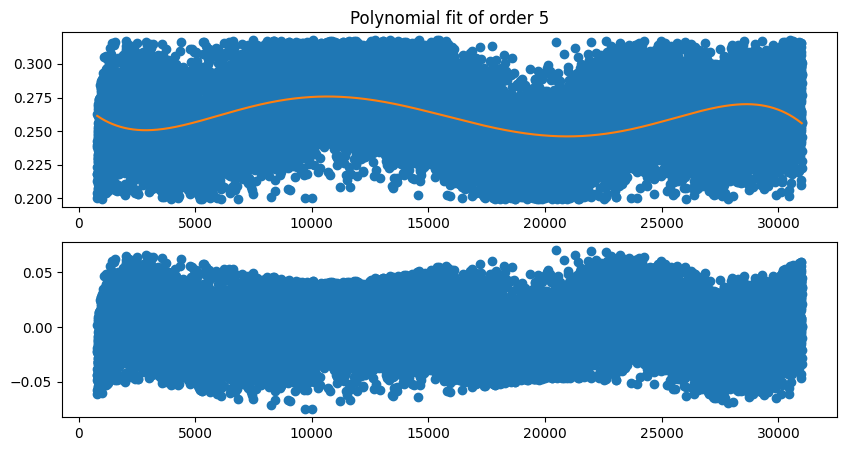

Order: 5, BIC: -222541.5040682036, ΔBIC: -2091.5817066633317


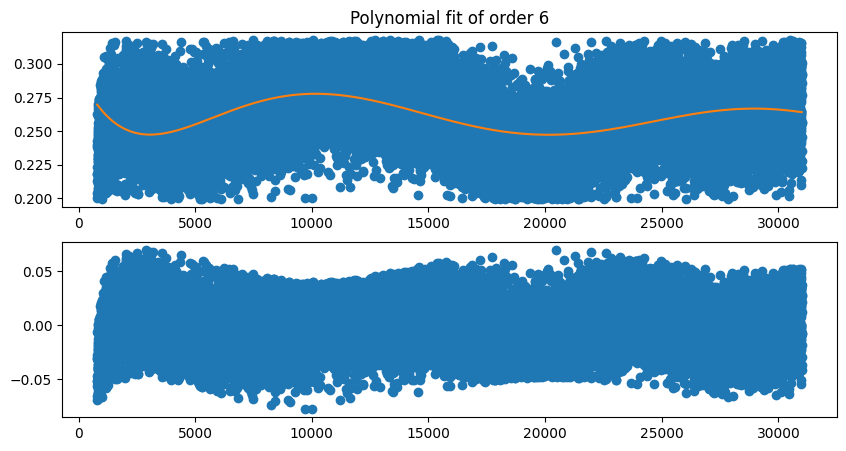

Order: 6, BIC: -222843.74174013975, ΔBIC: -302.2376719361637


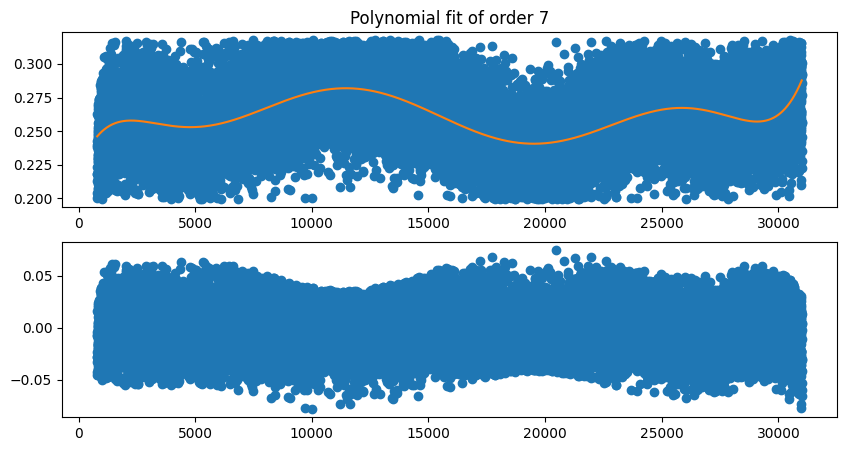

Order: 7, BIC: -225135.3515007386, ΔBIC: -2291.6097605988325


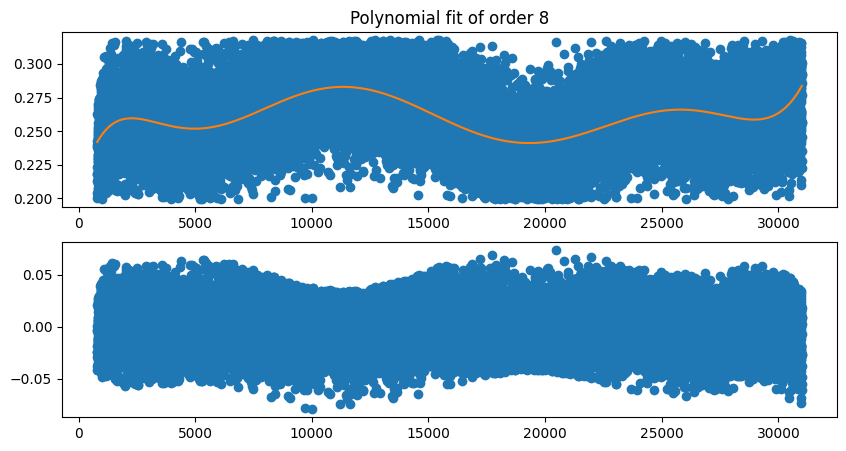

Order: 8, BIC: -225191.85544268065, ΔBIC: -56.50394194206456


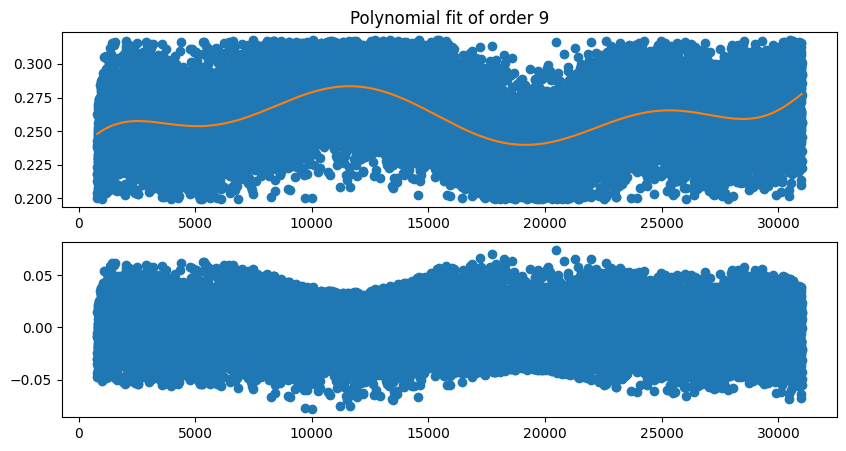

Order: 9, BIC: -225300.14164868926, ΔBIC: -108.2862060086045


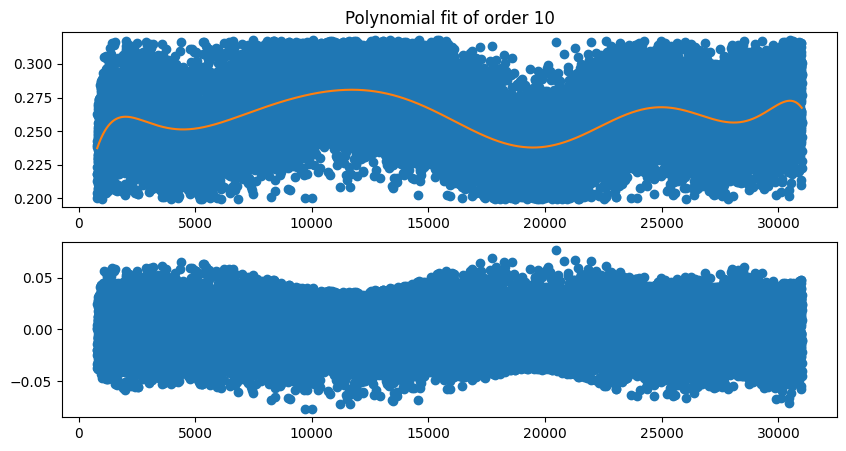

Order: 10, BIC: -225624.77725162523, ΔBIC: -324.635602935974


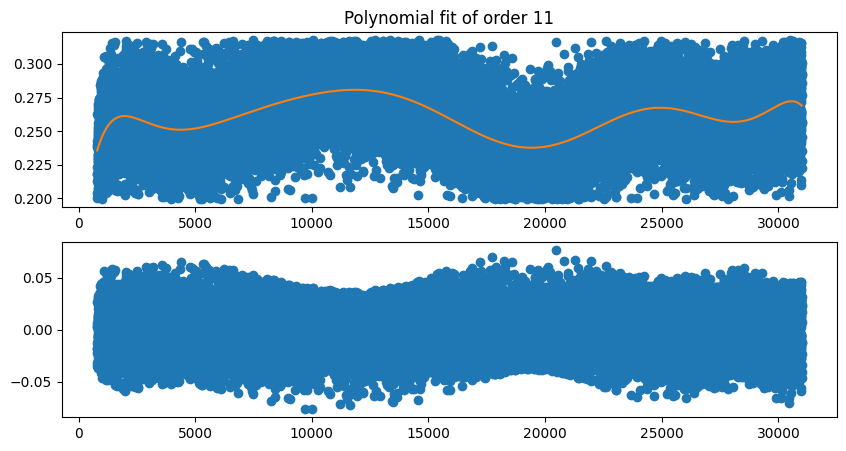

Order: 11, BIC: -225622.46013070983, ΔBIC: 2.3171209153952077


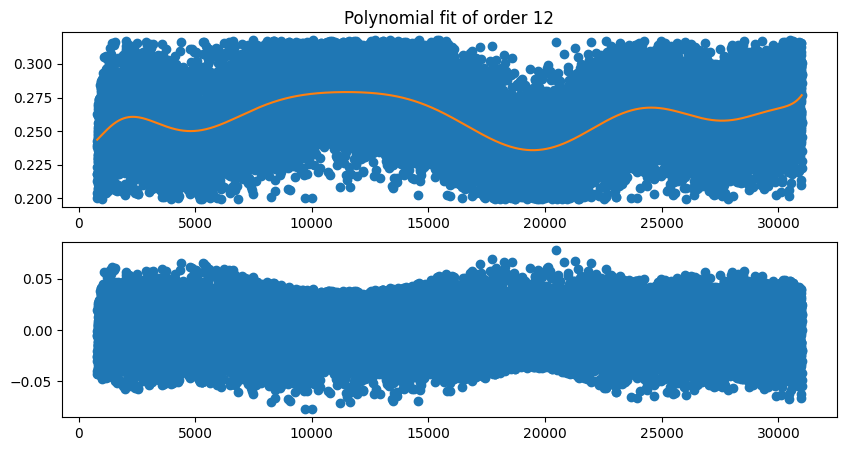

Order: 12, BIC: -225773.27547332394, ΔBIC: -150.81534261410707


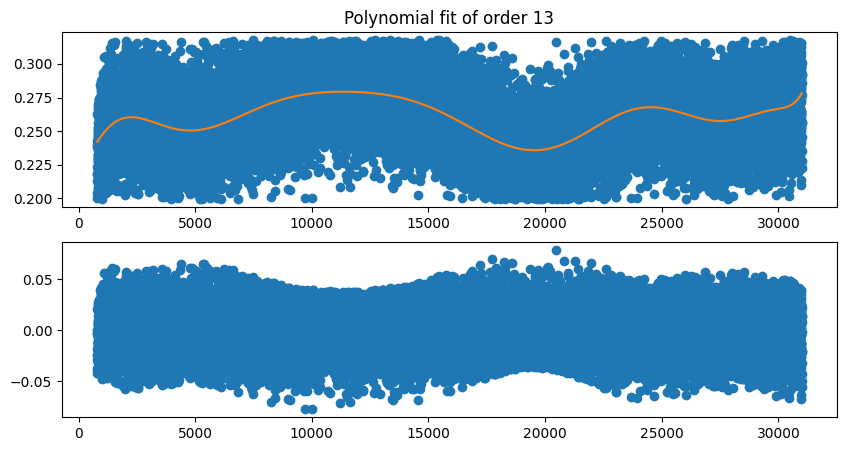

Order: 13, BIC: -225768.66019916677, ΔBIC: 4.6152741571713705


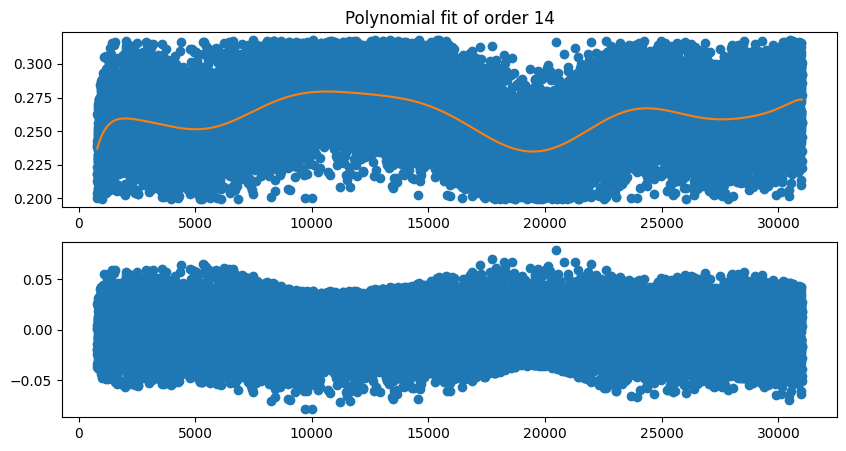

Order: 14, BIC: -225811.70344660027, ΔBIC: -43.04324743349571


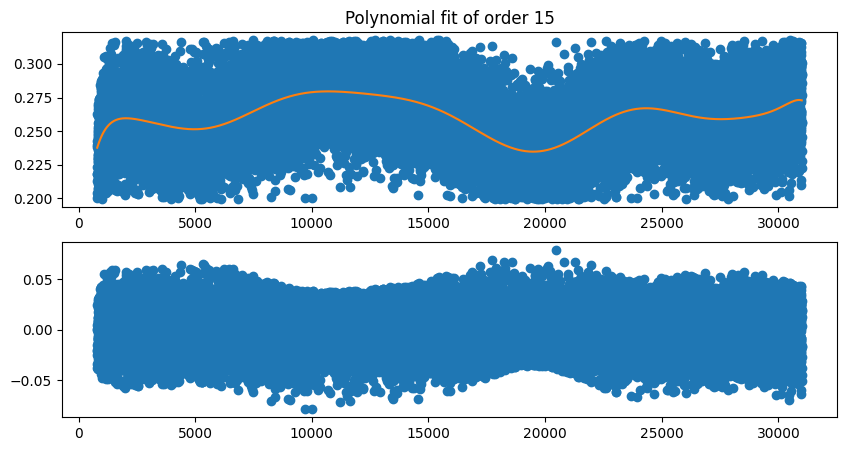

Order: 15, BIC: -225802.25065189117, ΔBIC: 9.452794709097361


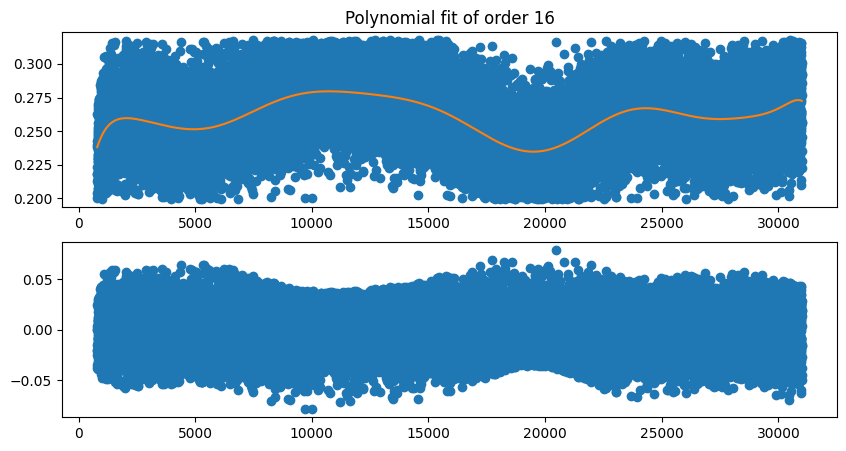

Order: 16, BIC: -225792.0348612124, ΔBIC: 10.215790678776102


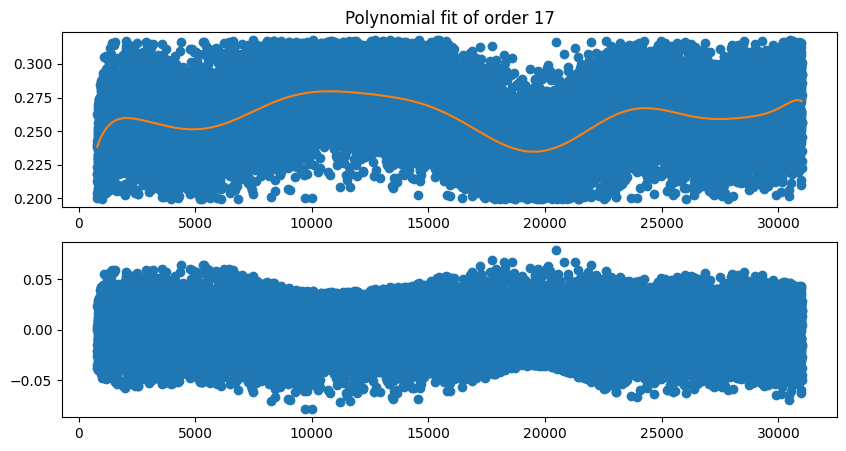

Order: 17, BIC: -225781.36327085167, ΔBIC: 10.671590360725531


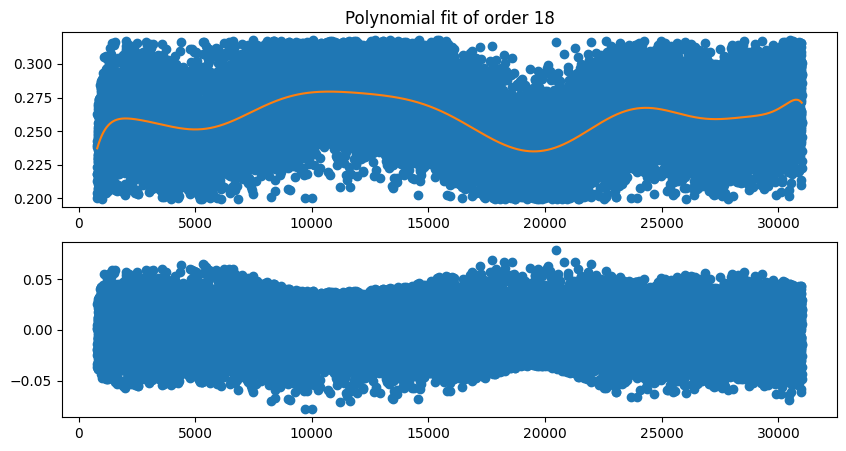

Order: 18, BIC: -225774.00441778335, ΔBIC: 7.358853068319149


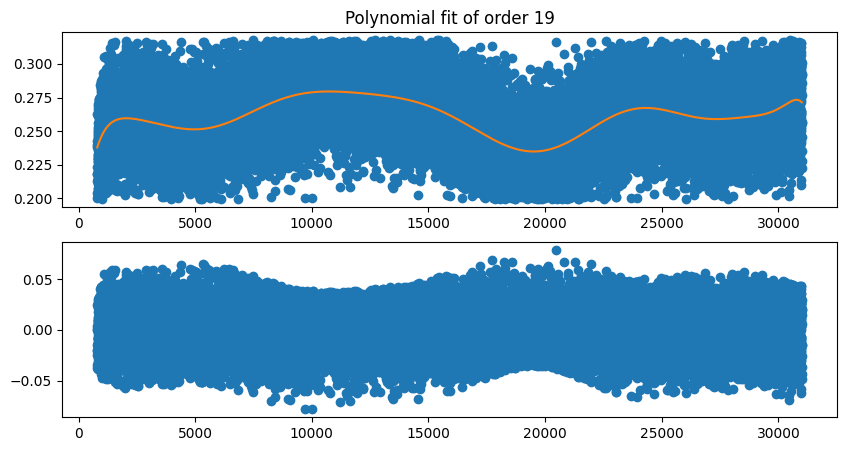

Order: 19, BIC: -225761.81894340416, ΔBIC: 12.185474379191874
Recommended polynomial order (BIC): 0


In [139]:
best_order_bic = 0
maybe_best_order = 0
best_bic = float('inf')

n = len(mask_chan)  # Number of data points
del_bic = []
bic_list = []
for i in range(0, 20):
    order = i
    coeff, residuals, _, _, _ = np.polyfit(mask_chan, flagged_flux_values[mask_chan], deg=order, full=True)

    # Plot both the fit and residuals
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    ax[0].plot(mask_chan, flagged_flux_values[mask_chan], 'o', label='data')
    ax[0].plot(mask_chan, np.polyval(coeff, mask_chan), label='fit')
    ax[1].plot(mask_chan, flagged_flux_values[mask_chan] - np.polyval(coeff, mask_chan), 'o')
    ax[0].set_title(f"Polynomial fit of order {order}")
    plt.show()

    rss = residuals[0] if len(residuals) > 0 else np.sum((flagged_flux_values[mask_chan] - np.polyval(coeff, mask_chan))**2)
    k = order + 1  # Number of parameters

    # Manually calculate BIC
    bic = n * np.log(rss / n) + k * np.log(n)
    bic_list.append(bic)
    if i > 0:  # Check if new BIC is significantly better
        delta_bic = bic - best_bic
        del_bic.append(delta_bic)
        print(f"Order: {order}, BIC: {bic}, ΔBIC: {delta_bic}")
        best_bic = bic
        

print(f"Recommended polynomial order (BIC): {best_order_bic}")


In [ ]:
#choose the best del_bic from the list
for dbic in del_bic:


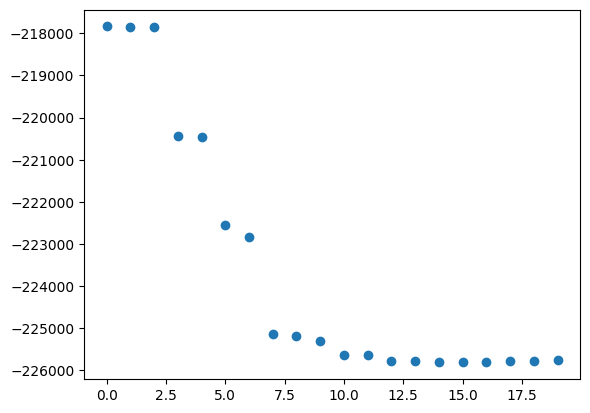

In [140]:
plt.scatter(range(0,len(bic_list),1), bic_list)

In [12]:
len(flagged_flux_values[mask_chan])

29275

In [13]:
mask_chan = list(mask_chan) 
mask_chan
exclude_chan = list(exclude_chan[lower_bound:upper_bound])
exclude_chan

[np.int64(803),
 np.int64(804),
 np.int64(807),
 np.int64(816),
 np.int64(818),
 np.int64(849),
 np.int64(856),
 np.int64(870),
 np.int64(925),
 np.int64(951),
 np.int64(960),
 np.int64(1016),
 np.int64(1109),
 np.int64(1403),
 np.int64(1441),
 np.int64(1450),
 np.int64(1519),
 np.int64(1769),
 np.int64(1886),
 np.int64(1899),
 np.int64(1902),
 np.int64(2070),
 np.int64(2265),
 np.int64(2479),
 np.int64(2618),
 np.int64(2705),
 np.int64(2716),
 np.int64(2801),
 np.int64(2933),
 np.int64(2947),
 np.int64(3406),
 np.int64(3411),
 np.int64(3531),
 np.int64(3776),
 np.int64(3852),
 np.int64(4014),
 np.int64(4298),
 np.int64(4363),
 np.int64(4481),
 np.int64(4679),
 np.int64(4725),
 np.int64(4835),
 np.int64(4856),
 np.int64(4904),
 np.int64(4916),
 np.int64(4934),
 np.int64(5007),
 np.int64(5045),
 np.int64(5140),
 np.int64(5157),
 np.int64(5158),
 np.int64(5165),
 np.int64(5174),
 np.int64(5179),
 np.int64(5184),
 np.int64(5194),
 np.int64(5196),
 np.int64(5199),
 np.int64(5203),
 np.int6

In [41]:
flag_freq = flagged_spectra.frequency.to(u.Hz)

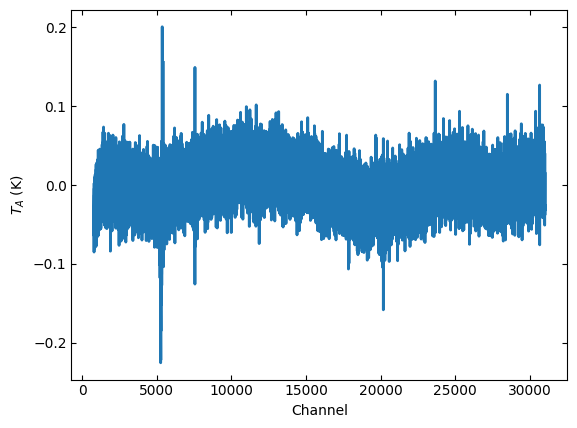

In [147]:
ps.baseline(model="poly", degree=0, remove=True)
ps.plot(xaxis_unit="chan")


In [72]:
def group_excluded_channels(exclude_chan, gap_threshold=100):
    if not exclude_chan:
        return []

    exclude_chan.sort()
    grouped = []
    start = exclude_chan[0]

    for i in range(1, len(exclude_chan)):
        if exclude_chan[i] - exclude_chan[i - 1] > gap_threshold:
            grouped.append((start, exclude_chan[i - 1]))
            start = exclude_chan[i]

    grouped.append((start, exclude_chan[-1]))

    for i in grouped:
        if i[1] == i[0]:
            grouped.remove(i)
            grouped.append((i[0], i[0]+1))
    return grouped

# Example usage
exclude_chan_ex = [1, 2, 3, 4, 10, 12, 13, 14, 25, 26, 27, 30]
result = group_excluded_channels(exclude_chan, gap_threshold=100)  # Adjust threshold if needed
print(result)  # Output: [(1, 4), (10, 14), (25, 30)]

[(np.int64(803), np.int64(1109)), (np.int64(1403), np.int64(1519)), (np.int64(1886), np.int64(1902)), (np.int64(2265), np.int64(2265)), (np.int64(2618), np.int64(2801)), (np.int64(2933), np.int64(2947)), (np.int64(3406), np.int64(3411)), (np.int64(3776), np.int64(3852)), (np.int64(4298), np.int64(4363)), (np.int64(4679), np.int64(4725)), (np.int64(4835), np.int64(5501)), (np.int64(5675), np.int64(5886)), (np.int64(6139), np.int64(6309)), (np.int64(6624), np.int64(6640)), (np.int64(7337), np.int64(7391)), (np.int64(7560), np.int64(7788)), (np.int64(7975), np.int64(8049)), (np.int64(8338), np.int64(8545)), (np.int64(8689), np.int64(8800)), (np.int64(8922), np.int64(9105)), (np.int64(9210), np.int64(9375)), (np.int64(9566), np.int64(9813)), (np.int64(9976), np.int64(12038)), (np.int64(12161), np.int64(12595)), (np.int64(12698), np.int64(13685)), (np.int64(13793), np.int64(13877)), (np.int64(14121), np.int64(14274)), (np.int64(14398), np.int64(14555)), (np.int64(14688), np.int64(14869)), (

In [74]:
for i in result:
    if i[0] == i[1]:
        print(i)

(np.int64(2265), np.int64(2265))
(np.int64(29873), np.int64(29873))


In [68]:
flagged_spectra.baseline(model = 'poly', degree=recommended_order, exclude=result, remove=True)
flagged_spectra.plot(xaxis_unit="chan")

ValueError: Upper and lower bound must be different values.

In [142]:
smoothing = 5/(ps.velocity[3]-ps.velocity[2]).value

In [143]:
smoothing

np.float64(33.30815680378907)

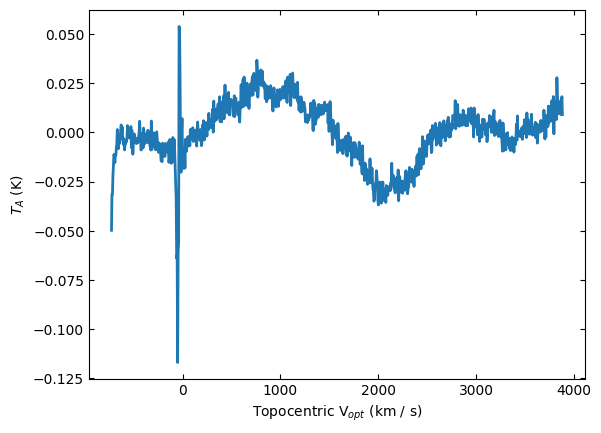

In [148]:
new_ps_smooth = ps.smooth('boxcar', int(smoothing))
new_ps_smooth.plot(xaxis_unit="km/s")


Adjusting decimation factor to be a natural number. Will decimate by 33


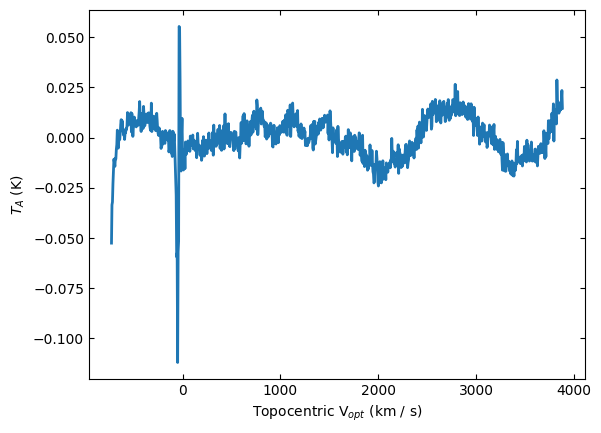

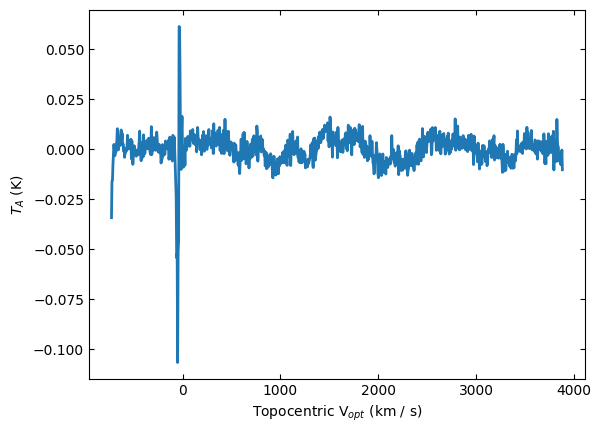

In [51]:
new_flagged_smooth = flagged_spectra.smooth('boxcar', smoothing)
new_ps_smooth.plot(xaxis_unit="km/s")
new_flagged_smooth.plot(xaxis_unit="km/s")